In [1]:
!pip install simpy xgboost scikit-learn pandas numpy matplotlib seaborn

In [2]:
import simpy
import random
import pandas as pd
import numpy as np

def atm_process(env, customer, atm, service_time):
    arrival_time = env.now
    with atm.request() as request:
        yield request
        wait_time = env.now - arrival_time
        yield env.timeout(random.expovariate(1.0 / service_time))
        return wait_time

def run_simulation(arrival_rate, service_time, num_atms):
    env = simpy.Environment()
    atm = simpy.Resource(env, capacity=num_atms)
    wait_times = []

    def setup(env):
        i = 0
        while True:
            yield env.timeout(random.expovariate(arrival_rate))
            i += 1
            env.process(customer_wrapper(env, f'Cust {i}', atm, service_time, wait_times))

    def customer_wrapper(env, name, atm, service_time, wait_times):
        wt = yield from atm_process(env, name, atm, service_time)
        wait_times.append(wt)

    env.process(setup(env))
    env.run(until=100) # Run for 100 time units
    return np.mean(wait_times) if wait_times else 0

In [3]:
data = []

for _ in range(1000):
    arrival_rate = random.uniform(0.5, 5.0)
    service_time = random.uniform(1.0, 10.0)
    num_atms = random.randint(1, 5)

    avg_wait = run_simulation(arrival_rate, service_time, num_atms)
    
    data.append({
        'arrival_rate': arrival_rate,
        'service_time': service_time,
        'num_atms': num_atms,
        'avg_wait': avg_wait
    })

df = pd.DataFrame(data)
df.to_csv('simulation_data.csv', index=False)
print("Dataset Generated: 1000 samples.")
df.head()

Dataset Generated: 1000 samples.


,arrival_rate,service_time,num_atms,avg_wait
0,0.683999,6.145137,5,0.079019
1,1.360931,4.593746,3,21.736328
2,2.077538,6.125861,5,25.715844
3,3.097075,8.030220,4,33.503112
4,4.946871,6.850033,2,44.170436


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score

X = df.drop('avg_wait', axis=1)
y = df['avg_wait']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Random Forest": RandomForestRegressor(n_estimators=100),
    "Gradient Boosting": GradientBoostingRegressor(),
    "SVR": SVR(),
    "KNN": KNeighborsRegressor(),
    "XGBoost": XGBRegressor()
}

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    results.append({"Model": name, "MAE": mae, "R2 Score": r2})

results_df = pd.DataFrame(results).sort_values(by="MAE")
print(results_df)

               Model       MAE  R2 Score
5                KNN  4.399478  0.809103
2      Random Forest  4.449992  0.805089
3  Gradient Boosting  4.510709  0.807258
4                SVR  4.615004  0.780895
6            XGBoost  4.652107  0.786261
1   Ridge Regression  5.998671  0.654072
0  Linear Regression  5.999046  0.654023


C:\Users\HP\AppData\Local\Temp\ipykernel_10872\1517081696.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='MAE', y='Model', data=results_df, palette='viridis')


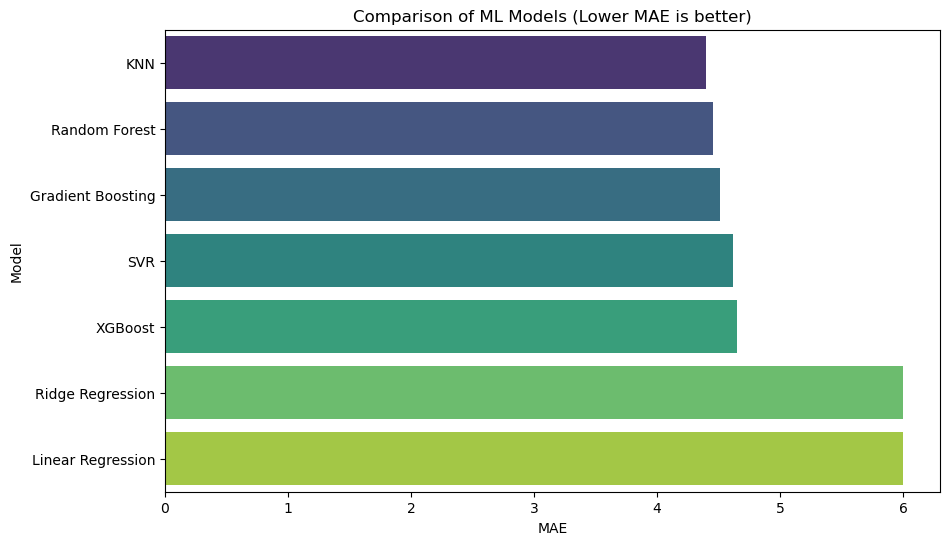

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x='MAE', y='Model', data=results_df, palette='viridis')
plt.title('Comparison of ML Models (Lower MAE is better)')

plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')

plt.show()